### In this notebook we extract and label all the entities from the Wiki-TabNER dataset

In [1]:
import json
import numpy as np
import pandas as pd
import urllib
from bs4 import BeautifulSoup
from tqdm import tqdm
from wikimapper import WikiMapper

In [2]:
from pathlib import Path
import pickle
from ast import literal_eval

### 1. Extract all the entities that appear in the Wiki-TabNER tables 


In [3]:
def create_entities_dataset(data_path):
    # Extracts all the entities which have a surfaceLink (link to the actual entity in Wikipedia)
    dataset_entities = pd.DataFrame(columns=["entity"])
    with tqdm() as progress:
        with pd.read_json(data_path, lines=True, chunksize=500) as reader:
                for chunk in reader:
                    for index, t in chunk.iterrows():
                        
                        numcols = t['numCols']
                        table = t["tableData"]
                        data_rows = [ r for r in table ]                

                        for col_index in range(numcols):

                            cells = [row[col_index] for row in data_rows ] 
                            entities = [] 
                            for cell in cells:
                                entities.append([cell['surfaceLinks'][i]['target']['title'] for i in range(len(cell['surfaceLinks']))])
                            new_rows = pd.DataFrame([{"entity": e} for e in entities])
                            dataset_entities = pd.concat([dataset_entities,new_rows],ignore_index=True)
                        progress.update()

    return dataset_entities

In [ ]:
# create dataset of entities

data_path = "../data/wiki_tabner_original_clean.json"
dataset_entities = create_entities_dataset(data_path=data_path)
print(len(dataset_entities))

dataset_entities = dataset_entities.explode("entity",ignore_index=True)

filepath = Path('../data/labeled_entities/wiki_tabner_dataset_entities_expanded.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
dataset_entities.to_csv(filepath) 

#### If the entities are already extracted, load into pandas for labeling

In [3]:
dataset_entities = pd.read_csv('../data/labeled_entities/wiki_tabner_dataset_entities_expanded.csv',index_col=0)

In [4]:
dataset_entities=dataset_entities.drop_duplicates().reset_index(drop=True)
dataset_entities=dataset_entities.dropna()
len(dataset_entities) # number of unique linked entities which appear in the tables

803692

In [5]:
dataset_entities.head(5)

,entity
0,1955_NCAA_Men's_Division_I_Basketball_Tournament
1,1956_NCAA_Men's_Division_I_Basketball_Tournament
2,1962_NCAA_Men's_Division_I_Basketball_Tournament
3,1973_NCAA_Men's_Division_I_Basketball_Tournament
4,1976_NCAA_Men's_Division_I_Basketball_Tournament


### Next, we load the labeled instances from dbpedia and we join them to the extracted entities from the tables

In [7]:
dbpedia=pd.read_table("../data/dbpedia/instance-types_lang=en_specific.ttl",names=["entity","type","class","dot"],sep=" ")

In [8]:
dbpedia.drop(["dot","type"],axis='columns',inplace=True)

In [9]:
dbpedia = dbpedia.loc[dbpedia["class"].str.contains(pat = "http://dbpedia.org/ontology/")]
dbpedia["entity"] = dbpedia["entity"].map(lambda x : urllib.parse.unwrap(x).replace('http://dbpedia.org/resource/',''))
dbpedia["class"] = dbpedia["class"].map(lambda x : urllib.parse.unwrap(x).replace('http://dbpedia.org/ontology/',''))
print(len(dbpedia))

6992319


In [10]:
dataset_entities_classes = dataset_entities.join(dbpedia.set_index('entity'), on="entity",how="left").reset_index(drop=True)

In [11]:
# Removing all the entities which don't appear in the dbpedia instances
dataset_entities_classes=dataset_entities_classes.loc[dataset_entities_classes["class"].notna()]
print(len(dataset_entities_classes))
print(dataset_entities_classes)

363510
                                                   entity           class
36          1982–83_Houston_Cougars_men's_basketball_team  NCAATeamSeason
61      2006–07_Ohio_State_Buckeyes_men's_basketball_team  NCAATeamSeason
64      2007–08_Michigan_State_Spartans_men's_basketba...  NCAATeamSeason
66              2007–08_UCLA_Bruins_men's_basketball_team  NCAATeamSeason
67          2007–08_Kansas_Jayhawks_men's_basketball_team  NCAATeamSeason
...                                                   ...             ...
803680                                    Larisa_Tsaryova         Athlete
803681                                      Natalia_Pokas         Athlete
803682                                   Irina_Gerasimova         Athlete
803684                           Susanne_Müller_(swimmer)         Athlete
803690                                  Deborah_Babashoff         Swimmer

[363510 rows x 2 columns]


### We load the dbpedia tree of classes to find the corresponding parent classes. We map the entities to their most general class (entity of class Swimmer will be labeled as Person)

In [12]:
with open('../data/dbpedia/dbpedia_classes.json', 'r') as f:
    tree = json.load(f)

In [17]:
# Here expanding the tree of classes in Dbpedia
entity_tree=expand(tree)
with open('../data/dbpedia/entity_tree_dbs.json', 'w') as f:
    json.dump(entity_tree, f)

In [18]:
print(set(assemble_entities(entity_tree))==set(dataset_entities_classes["entity"].to_list()))
print(len(assemble_entities(entity_tree))==363510) 

True
True


In [20]:
dataset_entities_classes["entity"].isna().sum()

0

In [32]:
count_labels = dataset_entities_classes.groupby(["class"]).count()["entity"].sort_values(ascending=False)

In [50]:
count_labels.head(15)

class
Person                  36278
Athlete                 28491
Film                    24405
Settlement              17276
Politician              15406
MusicalArtist            8236
SoccerPlayer             7696
Town                     7626
City                     7542
Song                     6838
BaseballPlayer           6606
Cyclist                  6364
AdministrativeRegion     6114
Album                    5819
BasketballPlayer         5150
Name: entity, dtype: int64

In [26]:
# These are the most general classes in Dbpedia
entity_tree["owl:Thing"].keys()

dict_keys(['Activity', 'Agent', 'Algorithm', 'Altitude', 'AnatomicalStructure', 'ArchitecturalStructure', 'Area', 'Award', 'Biomolecule', 'Blazon', 'Browser', 'Cartoon', 'ChartsPlacements', 'ChemicalSubstance', 'Cipher', 'Colour', 'Covid19', 'Currency', 'Demographics', 'Depth', 'Device', 'Diploma', 'Disease', 'ElectionDiagram', 'EthnicGroup', 'Event', 'FileSystem', 'Flag', 'Food', 'GeneLocation', 'GrossDomesticProduct', 'GrossDomesticProductPerCapita', 'Holiday', 'Hospital', 'Identifier', 'Language', 'List', 'MeanOfTransportation', 'Media', 'MedicalSpecialty', 'Medicine', 'MouseGene', 'Name', 'Novel', 'Pandemic', 'PersonFunction', 'Place', 'Population', 'Protocol', 'PublicService', 'Relationship', 'Skos', 'Species', 'SportCompetitionResult', 'SportsSeason', 'Spreadsheet', 'StarCluster', 'Statistic', 'Tank', 'TimePeriod', 'TopicalConcept', 'UnitOfWork', 'Unknown', 'Work', 'cidoccrm:E4_Period', 'd0:Activity', 'foaf:Image', 'foaf:Person', 'geo:SpatialThing', 'gml:_Feature', 'prov:Entity',

In [22]:
# We label the dataset entities with the following 7 classes
labels_dict = {"Activity": [], "Organisation": [], "ArchitecturalStructure":[], "Event":[], "Place":[], "Person":[], "Work":[]}

In [23]:
# populate Person
populate_main_classes(labels_dict,entity_tree["owl:Thing"]["Species"]["Eukaryote"]["Animal"])
# populate Organization
populate_main_classes(labels_dict,entity_tree["owl:Thing"]["Agent"])
# the rest: Activity, Event, Place, ArchStruct, Work
populate_main_classes(labels_dict,entity_tree["owl:Thing"])

In [56]:
# Transform into dataframe to be able to join to WikiIDs

In [24]:
entity_class_pairs = [(entity,class_name) for class_name, entities in labels_dict.items() for entity in entities]
labeled_entities =  pd.DataFrame(entity_class_pairs,columns=['entity','class'])

In [25]:
class_count=labeled_entities.groupby(["class"]).count()["entity"]

In [26]:
class_count

class
Activity                     154
ArchitecturalStructure     18326
Event                      14706
Organisation               25331
Person                    184038
Place                      49884
Work                       48662
Name: entity, dtype: int64

In [27]:
len(labeled_entities)

341101

### We now map the labeled entities to their Wikidata IDs

In [28]:
from wikimapper import WikiMapper

mapper = WikiMapper("../data/dbpedia/index_enwiki-latest.db")

labeled_entities["wikidata_id"] = labeled_entities.apply(lambda x : mapper.title_to_id(x["entity"]),axis=1)
print(labeled_entities)
print(labeled_entities["wikidata_id"].isnull().sum())

                       entity     class wikidata_id
0             Monopoly_(game)  Activity      Q17243
1                      Cluedo  Activity      Q17245
2               Hide-and-seek  Activity     Q171957
3                    Scrabble  Activity     Q170436
4                 Spelljammer  Activity    Q1060172
...                       ...       ...         ...
341096      The_Constant_Wife      Work    Q7727425
341097  A_Few_Good_Men_(play)      Work    Q2595865
341098       The_Lower_Depths      Work    Q1330429
341099               Vellekla      Work    Q3373410
341100       Arinbjarnarkviða      Work    Q3622616

[341101 rows x 3 columns]
36


In [58]:
filepath = Path('../data/full_dataset_entities_labels_dbp.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
labeled_entities.to_csv(filepath) 

In [59]:
labeled_entities[labeled_entities["entity"]=="Robbie_Williams"]

,entity,class,wikidata_id


There are still many entities for we expect to have the label, so we do the same procedure of labeling with Yago instance data. To be consistent, we map the Yago classes also to the Dbpedia tree. 

### Load the labeled instance data from Yago

In [32]:
yago=pd.read_table("../data/dbpedia/instance-types_tag=specific.ttl",names=["entity","type","class","dot"],sep=" ")

In [33]:
yago.drop(["dot","type"],axis='columns',inplace=True)

In [34]:
yago.head(5)

,entity,class
0,#,2016-10-07T07:09:03Z
1,<http://dbpedia.org/resource/!!!>,<http://dbpedia.org/class/yago/Abstraction1000...
2,<http://dbpedia.org/resource/!!!>,<http://dbpedia.org/class/yago/DanceBand108249...
3,<http://dbpedia.org/resource/!!!>,<http://dbpedia.org/class/yago/Group100031264>
4,<http://dbpedia.org/resource/!!!>,<http://dbpedia.org/class/yago/MusicalOrganiza...


In [63]:
#dbpedia had 6707444 entities and classes, yago has 57878998

In [35]:
yago = yago.loc[yago["class"].str.contains(pat = "http://dbpedia.org/class/yago/")]
yago["entity"] = yago["entity"].map(lambda x : urllib.parse.unwrap(x).replace('http://dbpedia.org/resource/',''))
yago["class"] = yago["class"].map(lambda x : urllib.parse.unwrap(x).replace('http://dbpedia.org/class/yago/',''))

57878998


In [36]:
yago["class"] = yago["class"].str.replace('\d+', '', regex=True)

In [37]:
yago['class'].unique()

array(['Abstraction', 'DanceBand', 'Group', ...,
       'WikicatDefunctMotorVehicleBrandsOfJapan',
       'WikicatNovelsByLualhatiBautista', 'WikicatKlingon-languageOperas'],
      dtype=object)

In [44]:
len(yago)

38610832

In [45]:
yago = yago[~yago['class'].astype(str).str.startswith('Wiki')]
yago = yago[~yago['class'].astype(str).str.startswith('Yago')]

In [46]:
len(yago) # after removing classes which start with wiki and yago down to 38610832

38610832

### Next step is to join the entities with the instance data from Yago 

In [49]:
dataset_entities_classes = dataset_entities.join(yago.set_index('entity'), on="entity",how="left").reset_index(drop=True)
dataset_entities_classes=dataset_entities_classes.loc[dataset_entities_classes["class"].notna()]
print(len(dataset_entities_classes))
print(dataset_entities_classes)

5359704
                                                   entity  \
0        1955_NCAA_Men's_Division_I_Basketball_Tournament   
1        1955_NCAA_Men's_Division_I_Basketball_Tournament   
2        1955_NCAA_Men's_Division_I_Basketball_Tournament   
3        1955_NCAA_Men's_Division_I_Basketball_Tournament   
4        1955_NCAA_Men's_Division_I_Basketball_Tournament   
...                                                   ...   
5717320                                 Deborah_Babashoff   
5717321                                 Deborah_Babashoff   
5717322                                 Deborah_Babashoff   
5717323                                 Deborah_Babashoff   
5717324                                 Deborah_Babashoff   

                        class  
0                 Abstraction  
1                     Contest  
2                       Event  
3        PsychologicalFeature  
4                 SocialEvent  
...                       ...  
5717320              Organism  
571

In [50]:
classes= dataset_entities_classes["class"].unique()
len(dataset_entities_classes["class"].unique())

6355

In [43]:
class_count=dataset_entities_classes.groupby(["class"]).count()["entity"].sort_values(ascending=False)
class_count.head(10)
len(dataset_entities_classes)

5717326

### Map the entities and their classes to the Dbpedia class hierarchy

In [51]:
with open('../data/dbpedia/dbpedia_classes.json', 'r') as f:
    tree = json.load(f)

In [52]:
from pprint import pprint
import json

with open('../data/dbpedia/dbpedia_classes.json', 'r') as f:
    tree = json.load(f)
#pprint(tree)

def get_entities(subtree):
    result=[]
    for c,branch in subtree.items():
        result.extend([c])
        if branch !={}:
            result.extend([e for e in subtree[c]])
            branch_entities = get_entities(branch)
            result.extend([e for e in branch_entities])
    return result


classes = list(tree["owl:Thing"].keys())
my_tree= tree["owl:Thing"]

class2entity={ c: list(set(get_entities(my_tree[c]))) for c in classes}

print(class2entity)

entity2class ={} 
for c, entities in class2entity.items():
    for e in entities:
        entity2class[e]=c


e= "Beverage"

print(entity2class[e])

{'Activity': ['Game', 'TeamSport', 'Sport', 'Athletics', 'Sales', 'BoardGame', 'CardGame'], 'Agent': ['CyclingTeam', 'MixedMartialArtsLeague', 'AutoRacingLeague', 'School', 'GovernmentAgency', 'ComicsCharacter', 'CanadianFootballTeam', 'Brewery', 'GeopoliticalOrganisation', 'VolleyballLeague', 'NarutoCharacter', 'Non-ProfitOrganisation', 'PoliticalParty', 'PaintballLeague', 'RugbyClub', 'Library', 'BaseballTeam', 'SportsLeague', 'Winery', 'GovernmentCabinet', 'RugbyLeague', 'Family', 'Group', 'RadioStation', 'SambaSchool', 'TermOfOffice', 'MilitaryUnit', 'EmployersOrganisation', 'SpeedwayLeague', 'SoapCharacter', 'Deity', 'CricketLeague', 'CanadianFootballLeague', 'HandballTeam', 'HockeyTeam', 'Employer', 'BoxingLeague', 'InternationalOrganisation', 'Broadcaster', 'SoccerLeague', 'FormulaOneTeam', 'ClericalOrder', 'Organisation', 'Band', 'NationalSoccerClub', 'TennisLeague', 'BroadcastNetwork', 'Publisher', 'RecordOffice', 'BasketballTeam', 'SpeedwayTeam', 'FictionalCharacter', 'Record

In [16]:
def expand(tree):
    result=tree
    for c,branch in result.items():
        if c !="ENTITIES":
            result[c]["ENTITIES"] = dataset_entities_classes.loc[dataset_entities_classes["class"]==c]["entity"].to_list()
            if branch != {}:
                expand(branch)
    return result

In [53]:
with open('../data/dbpedia/entity_tree_yago.json', 'r') as f:
    entity_tree = json.load(f)

In [54]:
entity_tree['owl:Thing'].keys()

dict_keys(['Activity', 'Agent', 'Algorithm', 'Altitude', 'AnatomicalStructure', 'ArchitecturalStructure', 'Area', 'Award', 'Biomolecule', 'Blazon', 'Browser', 'Cartoon', 'ChartsPlacements', 'ChemicalSubstance', 'Cipher', 'Colour', 'Covid19', 'Currency', 'Demographics', 'Depth', 'Device', 'Diploma', 'Disease', 'ElectionDiagram', 'EthnicGroup', 'Event', 'FileSystem', 'Flag', 'Food', 'GeneLocation', 'GrossDomesticProduct', 'GrossDomesticProductPerCapita', 'Holiday', 'Hospital', 'Identifier', 'Language', 'List', 'MeanOfTransportation', 'Media', 'MedicalSpecialty', 'Medicine', 'MouseGene', 'Name', 'Novel', 'Pandemic', 'PersonFunction', 'Place', 'Population', 'Protocol', 'PublicService', 'Relationship', 'Skos', 'Species', 'SportCompetitionResult', 'SportsSeason', 'Spreadsheet', 'StarCluster', 'Statistic', 'Tank', 'TimePeriod', 'TopicalConcept', 'UnitOfWork', 'Unknown', 'Work', 'cidoccrm:E4_Period', 'd0:Activity', 'foaf:Image', 'foaf:Person', 'geo:SpatialThing', 'gml:_Feature', 'prov:Entity',

In [69]:
labels_dict = {"Activity": [], "Organisation": [], "ArchitecturalStructure":[], "Event":[], "Place":[], "Person":[], "Work":[]}

In [70]:
def populate_main_classes(flattened_dict, nested_dict, parent_key=""):
    for key, value in nested_dict.items():
        if key in flattened_dict:
            if "ENTITIES" in value:
                flattened_dict[key].extend(value["ENTITIES"])
            if isinstance(value, dict):
                flattened_dict[key].extend(assemble_entities(value))

In [71]:
def assemble_entities(subtree):
    result=[]
    for c,branch in subtree.items():
        if c != "ENTITIES":
            result.extend([e for e in subtree[c]["ENTITIES"]])
            branch_entities = assemble_entities(branch)
            result.extend([e for e in branch_entities])
    return result

In [72]:
print(len(assemble_entities(entity_tree))==647153) 

True


In [73]:
# populate Person
populate_main_classes(labels_dict,entity_tree["owl:Thing"]["Species"]["Eukaryote"]["Animal"])
# populate Organization
populate_main_classes(labels_dict,entity_tree["owl:Thing"]["Agent"])
# the rest: Activity, Event, Place, ArchStruct, Work
populate_main_classes(labels_dict,entity_tree["owl:Thing"])

In [74]:
for key, val in labels_dict.items():
    print(key, len(set(val)))

Activity 7393
Organisation 31946
ArchitecturalStructure 16052
Event 34616
Place 40227
Person 133215
Work 14341


In [76]:
entity_class_pairs_ = [(entity,class_name) for class_name, entities in labels_dict.items() for entity in entities]
entity_class_pairs = set(entity_class_pairs_)
labeled_entities_yago =  pd.DataFrame(entity_class_pairs,columns=['entity','class'])

In [77]:
class_count=labeled_entities_yago.groupby(["class"]).count()["entity"]
class_count

class
Activity                    7393
ArchitecturalStructure     16052
Event                      34616
Organisation               31946
Person                    133215
Place                      40227
Work                       14341
Name: entity, dtype: int64

In [78]:
len(labeled_entities_yago)

277790

### Map the labeled entities to their wikidata ids using the WikiMapper

In [64]:
from wikimapper import WikiMapper

mapper = WikiMapper("../data/dbpedia/index_enwiki-latest.db")

labeled_entities["wikidata_id"] = labeled_entities.apply(lambda x : mapper.title_to_id(x["entity"]),axis=1)
print(labeled_entities["wikidata_id"].isnull().sum())

36


In [66]:
labeled_entities_yago

,entity,class
0,Avram_Grant,Person
1,"Baikunthpur,_Koriya",Place
2,Anthony_Miller_(basketball),Person
3,Dale_Shearer,Person
4,Chris_Eaton_(rugby_union),Person
...,...,...
277785,Pippin_(musical),Work
277786,Zastron,Place
277787,Johan_Ramström,Person
277788,Suresh_Heblikar,Person


In [145]:
filepath = Path('../data/full_dataset_entities_labels_yago.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
labeled_entities.drop_duplicates(inplace=True)
labeled_entities.dropna(subset=['wikidata_id'], inplace=True)
labeled_entities.to_csv(filepath) 

In [146]:
len(labeled_entities["class"].unique())

7

In [147]:
labeled_entities.loc[labeled_entities["entity"].str.contains("Robbie_Williams")]

,entity,class,wikidata_id
254606,Robbie_Williams,Person,Q47875
262926,Robbie_Williamson,Person,Q7341028
602135,Greatest_Hits_(Robbie_Williams_album),Work,Q1028072
608500,Angels_(Robbie_Williams_song),Work,Q769491


In [149]:
class_count=labeled_entities.groupby( ["class"]).count()
class_count

,entity,wikidata_id
class,,
Activity,7344,7344
ArchitecturalStructure,16039,16039
Event,34528,34528
Organisation,31788,31788
Person,132533,132533
Place,40169,40169
Work,14275,14275


## Merging the labeled entities into one file

In [30]:
dataset_entities_dbp  = pd.read_csv('../data/labeled_entities/full_dataset_entities_labels_dbp.csv',index_col=0)
dataset_entities_dbp.dropna(inplace=True)

In [29]:
dataset_entities_yago = pd.read_csv('../data/labeled_entities/full_dataset_entities_labels_yago.csv',index_col=0)
dataset_entities_yago.dropna(inplace=True)

In [82]:
len(dataset_entities_dbp), len(dataset_entities_yago)

(341065, 276676)

In [83]:
dataset_entities_dbp['source'] = 'dbp'
dataset_entities_yago['source'] = 'yago'

In [84]:
merged_df = pd.concat([dataset_entities_dbp, dataset_entities_yago], axis = 0, ignore_index=True)

In [85]:
len(merged_df)

617741

In [86]:
merged_df.head(5)

,entity,class,wikidata_id,source
0,Monopoly_(game),Activity,Q17243,dbp
1,Cluedo,Activity,Q17245,dbp
2,Hide-and-seek,Activity,Q171957,dbp
3,Scrabble,Activity,Q170436,dbp
4,Spelljammer,Activity,Q1060172,dbp


In [87]:
# Identify duplicate entities
duplicate_entities = merged_df[merged_df.duplicated(subset=['entity','class','wikidata_id'], keep=False)]

In [88]:
len(duplicate_entities)

337298

In [89]:
merged_df = merged_df.drop_duplicates(subset=['entity','class','wikidata_id'], keep='first')

In [ ]:
duplicate_entity = merged_df[merged_df.duplicated(subset=['entity', 'wikidata_id'], keep=False)]

In [96]:
merged_df = merged_df.drop_duplicates(subset=['entity','wikidata_id'], keep='first')

In [97]:
len(merged_df)

408781

In [98]:
class_count = merged_df.groupby('class')['entity'].count().reset_index()

In [99]:
class_count

,class,entity
0,Activity,4229
1,ArchitecturalStructure,22294
2,Event,24789
3,Organisation,38406
4,Person,213114
5,Place,55043
6,Work,50906


In [105]:
count_dbp = merged_df[merged_df['source'] == 'dbp'].shape[0]
count_dbp

In [107]:
count_yago = merged_df[merged_df['source'] == 'yago'].shape[0]
count_yago

67716

In [172]:
merged_df.to_csv("../data/full_dataset_entities_labeled_dbp_yago_final.csv") # use this one for labeling the dataset

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

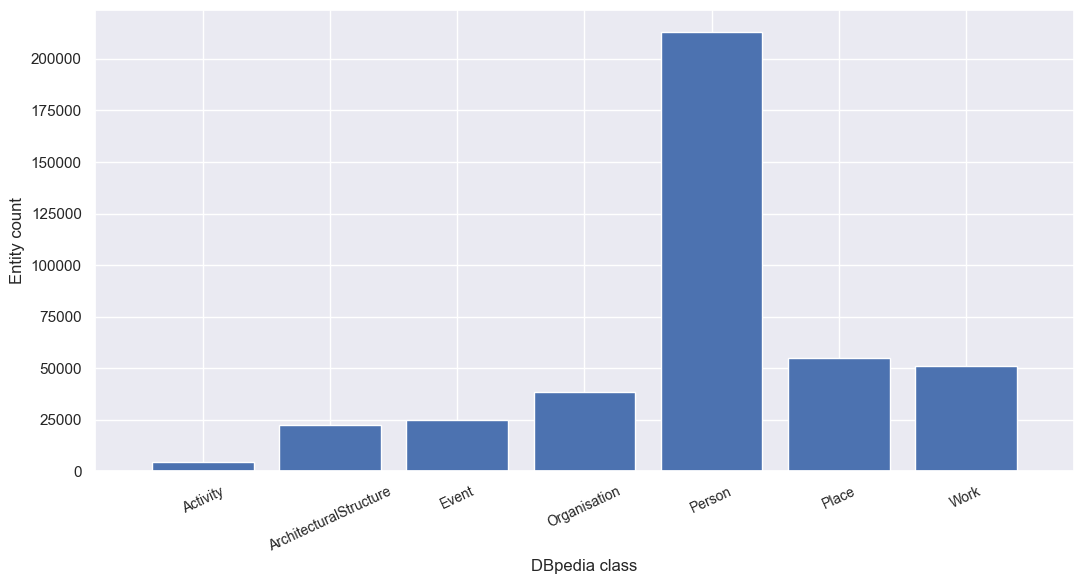

In [103]:
sns.set(rc={'figure.figsize':(11,6)})
fig, ax = plt.subplots(1)

sns.histplot(class_count,x="class",y="entity",ax=ax, stat="count", discrete=True)
ax.bar(class_count["class"],class_count["entity"])

ax.set(ylabel="Entity count")
ax.set(xlabel="DBpedia class")

plt.xticks(fontsize=10, rotation=25)
plt.tight_layout()
plt.savefig("plots/new_final_labeled_entities.png")

plt.show()

In [ ]:
|